## Pertpy Analysis 

In [ ]:
import pertpy as pt

import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (7,7)
import numpy as np
import pandas as pd
import scvi
sc.settings.verbosity = 3
import rpy2
import ete3


import scanpy as sc
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import anndata2ri

anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

In [2]:
#! pip install anndata2ri
#!pip install ete3

In [3]:
#!pip install mizani==0.9.1
#!pip install torchmetrics==0.11.4
#!pip install -q torch==2.0.0+cu118 torchmetrics==0.11.4 torchvision==0.15.1+cu118 torchaudio==2.0.1+cu118 torchtext==0.15.1 torchdata==0.6.0 --extra-index-url https://download.pytorch.org/wh1/cul18 -U
#!pip install pertpy

In [13]:
# path of partly preprocessed HLCA file used in this notebook:
#adata_path = "/home/h/hollenberg/MaPra/adata_radiation_processed.h5ad"
adata_path = "/home/h/hollenberg/MaPra/adata_processed_2_lea.h5ad"

# path to results directory:
dir_out = "/home/h/hollenberg/MaPra/"

In [14]:
adata = sc.read(adata_path)

In [15]:
milo = pt.tl.Milo()
mdata = milo.load(adata)

In [16]:
mdata

MuData object with n_obs × n_vars = 17544 × 18252
  2 modalities
    rna:	17544 x 18252
      obs:	'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'is_doublet'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
      uns:	'condition_colors', 'is_doublet_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'samples_colors', 'scrublet', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'log1p_norm'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

In [17]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
adata_scvi = adata[:, adata.var["highly_variable"]].copy()
scvi.model.SCVI.setup_anndata(adata_scvi, layer="log1p_norm", batch_key="condition")
model_scvi = scvi.model.SCVI(adata_scvi)
max_epochs_scvi = int(np.min([round((200 / adata.n_obs) * 400), 50]))
model_scvi.train(max_epochs=max_epochs_scvi)
adata.obsm["X_scVI"] = model_scvi.get_latent_representation()

## Build KNN graph


In [21]:
sc.pp.neighbors(mdata['rna'], use_rep='X_scVI', n_neighbors=150, n_pcs=10)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:35)


## Construct neighbourhoods



In [22]:
milo.make_nhoods(mdata['rna'], prop=0.1)
mdata['rna'].obsm["nhoods"]
mdata['rna'][mdata['rna'].obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

,nhood_ixs_refined,nhood_kth_distance
AAAGTAGAGAAACGCC-1,1,1.159875
AACTTTCAGAGTGACC-1,1,1.020193
AAGGAGCGTCTGATTG-1,1,0.927946
AAGGCAGTCTCGCATC-1,1,2.088737
ACCCACTAGAACTGTA-1,1,1.327079
...,...,...
TGGCCAGTCAACTCTT-1,1,1.332930
TGGCGCATCATGTAGC-1,1,1.180577
TGTGGTAGTTACAGAA-1-1,1,1.196121
TTAGGACAGCTAGCCC-1,1,0.979592


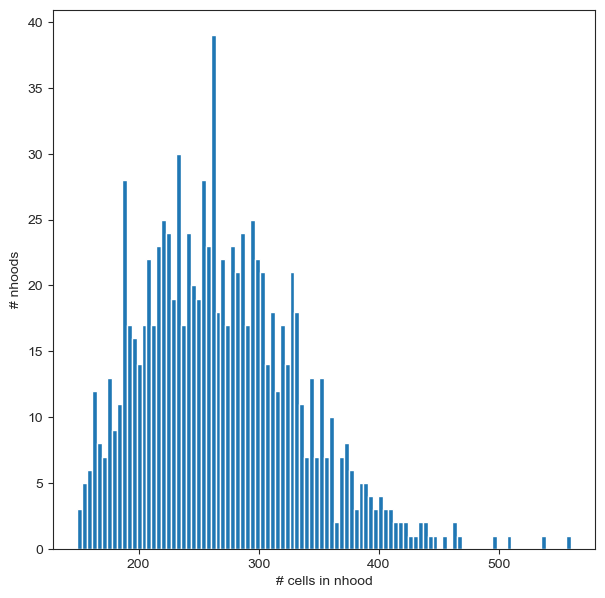

In [23]:
nhood_size = np.array(mdata['rna'].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);
plt.xlabel('# cells in nhood');
plt.ylabel('# nhoods');

## Count cells in neighbourhoods



In [24]:
mdata = milo.count_nhoods(mdata, sample_col="samples")
mdata

MuData object with n_obs × n_vars = 17544 × 18252
  2 modalities
    rna:	17544 x 18252
      obs:	'samples', 'GSM', 'condition', 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'is_doublet', 'nhood_ixs_random', 'nhood_ixs_refined', 'nhood_kth_distance'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'condition_colors', 'is_doublet_colors', 'neighbors', 'pca', 'predicted_doublet_colors', 'samples_colors', 'scrublet', 'umap', 'hvg', 'nhood_neighbors_key'
      obsm:	'X_pca', 'X_umap', 'X_scVI', 'nhoods'
      varm:	'PCs'
      layers:	'log1p_norm'
      obsp:	'connectivities', 'distances'
    milo:	11 x 963
      var:	'index_cell', 'kth_distance'
      uns:	'sample_col'

In [25]:
mdata['milo']

AnnData object with n_obs × n_vars = 11 × 963
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

## Differential abundance testing with GLM



In [30]:
# Reorder categories 
# (by default, the last category is taken as the condition of interest)

mdata['rna'].obs['condition'] = mdata['rna'].obs['condition'].cat.reorder_categories(['bleomycin', 'saline', "nintedanib"])
#mdata['rna'].obs['condition']

In [31]:
milo.da_nhoods(mdata, design='~condition')

Install Bioconductor library `'edgeR'` first as `BiocManager::install('edgeR').`

PackageNotInstalledError: The R package "edgeR" is not installed.

In [46]:
%%R
#if (!require("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
version()

#BiocManager::install('edgeR')
#library(edgeR)

[1] ‘3.10’


R[write to console]: Error in dev.off() : cannot shut down device 1 (the null device)



RRuntimeError: Error in dev.off() : cannot shut down device 1 (the null device)


In [ ]:
!conda install --channel https://conda.anaconda.org/bioconda bioconductor-edger

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::patsy==0.5.3=pyhd8ed1ab_0
  - conda-forge/noarch::scanpy==1.9.3=pyhd8ed1ab_0
  - conda-forge/noarch::typing-extensions==4.6.3=hd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.6.3=py39hf3d152e_0
  - conda-forge/linux-64::scikit-learn==1.2.2=py39hc236052_2
  - conda-forge/noarch::requests==2.31.0=pyhd8ed1ab_0
  - conda-forge/noarch::anndata==0.9.1=pyhd8ed1ab_0
  - conda-forge/linux-64::statsmodels==0.14.0=py39h0f8d45d_1
  - conda-forge/noarch::pooch==1.7.0=pyha770c72_3
  - conda-forge/linux-64::jupyter_core==5.3.1=py39hf3d152e_0
  - conda-forge/noarch::pynndescent==0.5.10=pyh1a96a4e_0
  - conda-forge/noarch::ipython==8.14.0=pyh41d4057_0
  - conda-forge/noarch::ipykernel==6.23.1=pyh210e3f2_0
  - conda-forge/noarch::jupyter_client==8.2.0=pyhd8ed1ab_0
  - conda-forge/linux-64::umap-learn==0.5.3=py39hf3d152e_1
  - co

In [ ]:
milo.da_nhoods(mdata, 
               design='~Status', 
               model_contrasts='StatusCovid-StatusHealthy')

In [ ]:
milo.da_nhoods(mdata, 
               design='~Site+Status', 
               model_contrasts='StatusCovid')

In [ ]:
mdata['milo'].obs


In [ ]:
mdata['milo'].var


In [ ]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(mdata['milo'].var.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(mdata['milo'].var.logFC, -np.log10(mdata['milo'].var.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize